<a href="https://colab.research.google.com/github/timsetsfire/wandb-examples/blob/main/colab/WB101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weights & Biases 101 🥾🏕️

This notebook is intended to show you how to track your machine learning experiments using [Weights & Biases](https://wandb.ai).

Weights & Biases has two major components: a python client named `wandb` 🪄🐝  and a web application that allows you to store, query, visualize, and share metadata from your machine learning experiments, e.g. loss curves, evaluation metrics, model predictions... you can `wandb.log` *just about* anything.

The client is open source and you can find the [source code on Github](http://github.com/wandb/wandb)! ⭐

The web application is publicly hosted at [wandb.ai](http://wandb.ai), but the app can be deployed in private environments as well. If you're interested in learning more about private deployments of the web app, check out [these docs](http://docs.wandb.ai/guides/self-hosted).

The first step on our journey is to install the client, which is as easy as:

In [ ]:
%%capture
!pip install wandb xgboost

## Client configuration

The first thing we do is set the `WANDB_PROJECT` environment variable. This tells the client to send all the data we log to a specific workspace in Weights & Biases. Environment variables are a great way to customize the behavior of the client without having to hardcode contextual details like a project name. You can check out [these docs](https://docs.wandb.ai/guides/track/advanced/environment-variables) for a complete list of the environment variables you can use to configure `wandb`.

In [ ]:
%env WANDB_PROJECT bootcamp
%env OPENAI_API_KEY

Next, we need to connect the client to an account in the web server. We do this in a notebook by calling `wandb.login`.

If you have Google SSO enabled for your Weights & Biases account and are running this notebook on colab, the authentication happens automatically when `wandb.login` is called.

Otherwise, you will see a authoriztion link and be asked to enter an API key. If you already have an account, you can follow the authorization link and then copy and paste the displayed API key. If you don't have an account you can sign up with an email address or using a Google or Github account.

In [ ]:
import wandb

# Equivalent to running "wandb login" in your shell
#
wandb.login(host="https://api.wandb.ai")

#
# Note that https://api.wandb.ai is the default and points to the publicly hosted
# app. You'll want to change this to a different API endpoint if you are trying
# to connect to a privately hosted server.
#
# Alternative you can configure this with environment variables:
# export WANDB_API_KEY="<your-api-key>"
# export WANDB_BASE_URL="<your-wandb-endpoint>"

Calling `wandb login` or `wandb.login` will write your API key to your `~/.netrc` file. __To authenticate the client in a headless job on the cloud, you will definitely want to use the `WANDB_API_KEY` environment variable__.

## Track your experiments

### `wandb.init`

The `wandb.init` function initializes a new `Run`, which you can think of as a comprehensive record of your machine learning experiment. Tracking starts when you call `wandb.init` and ends when you call `wandb.finish` (called automatically via `atexit` hooks if you don't want to invoke manually). You can also use python's `with` statement to initialize and finish runs (see code cell below).

### `wandb.log`

You can call `wandb.log` within your experiment add metrics to your `Run`. The idea is that you will call `wandb.log` many times over an experiment for the same metric, in which case the run saves the whole history of each metric across all of your `wandb.log` calls. The code cell below demonstrates how this looks in a typical stochastic gradient descent loop.




In [ ]:
%%wandb

config = dict(
  batch_size=32,
  learning_rate=1e-4,
  flux_capacitors=64,
  life_universe_everything=42,
)

"""
The pattern of "with wandb.init()..." causes wandb.finish() to be called as
soon as we leave the with block. This is especially useful when you have a script
or notebook that initializes multiple runs that you want to track separately.
"""
with wandb.init(config=config):

    artifact = wandb.Artifact(name = "tim-datasets", type = "datasets")
    artifact.add_dir("/content/sample_data")

    for key, value in dict(wandb.config).items():
        print(key, value)

    # Imagine we run 100 epochs of model training
    for x in range(2, 100):

        # Insert model training here...
        # ...

        # Compute metrics (or in this case, make them up)
        metrics = dict(
            loss=(1/x)**0.25,
            accuracy=1-(1/x)*2
        )

        # Pass metrics to Weights & Biases


    wandb.log_artifact(artifact, aliases = ["ready-to-move"])



### Anatomy of a `Run` 🩺

The `Run` stores a detailed record of an experiment within a few specific data structures. The important things to know about are
- `Run.config` is a dictionary like structure that stores configuration data for a run, like the path to input data or training hyperparameters. You can instatiate the config by passing a dictionary to `wandb.init(config=<config-dict>)`.
- `Run.history` is a list of dictionaries that stores historical values of metrics and media over the course of an experiment. We can append a new snapshot of our training metrics by calling `wandb.log(<metric-dict>)`
- `Run.summary` is a dictionary for recording summary metrics or media. By default the `summary` will contain the most recent values logged for each metric, you can overwrite and add elements as you like.


In [ ]:
import wandb
run = wandb.init()
artifact = run.use_artifact('tim-w/bootcamp/tim-datasets:v0', type='datasets')
artifact_dir = artifact.download()
wandb.finish()

## Log visualizations

The example we just ran shows you can log numerical metadata over the course of an experiment to Weights & Biases, and we saw how metrics like loss and accuracy show up as customizable line plots in the app. Now let's take a look at some of the other things you can `wandb.log` into your record of an experiment. You can see examples below, but for a first list of loggable types check out [these docs](https://docs.wandb.ai/ref/python/data-types).

### Log plots

Plotly is a popular library for building and rendering custom visualizations. It is tightly connected to the ubiquitous `matplotlib` package. We integrate with Plotly so that you can pass `matplotlib` or Plotly figures directly to `wandb.log`, which will automatically serialize and upload your figures to Weights & Biases, where they will be interactively rendered inside of your experiment records. You can run the cells below to see an example logging an interactive, 3D visualization to W&B.

In [ ]:
import plotly.express as px

In [ ]:
%%wandb

with wandb.init() as run:

  # Loads Iris dataset
  df = px.data.iris()

  # Construct a 3D scatter plot with plotly
  fig = px.scatter_3d(df,
                      x='sepal_length',
                      y='sepal_width',
                      z='petal_width',
                      color='species')

  # Log figure
  run.log({"figure": fig})

### Log dataframes

You can also log `pandas.DataFrame` objects with `wandb.log`! These will be converted into a `wandb.Table` (docs) and interactievly displayed inside of W&B. The cell below logs the entire Iris dataset and renders it in the W&B app 😎

Note: One of the most powerful features of `wandb.Table`s is that you can include any `wandb` type as a cell value! This includes, images, plots, videos, audio... almost anything 🤩

In [ ]:
%%wandb

with wandb.init() as run:

  # Log a pandas Dataframe to Weights & Biases
  wandb.log({"iris": px.data.iris()})

### Log HTML

You can use the `wandb.Html` class to pass in any HTML and have it saved and rendered in Weights & Biases. This allows indirect integration with all sorts of visualization libraries, like `displacy`.

In [ ]:
import spacy
from spacy import displacy

In [ ]:
%%wandb

with wandb.init() as run:

  # Process text and produce html visualizations
  text = "You can use Weights & Biases to log html, it's pretty wild."
  nlp = spacy.load("en_core_web_sm")
  doc = nlp(text)
  dep = displacy.render(doc, style="dep")

  # Log html to Weights & Biases
  run.log({"DEP": wandb.Html(dep)})

### Log sequences of media

If you periodically `wandb.log` a number (for example, loss), Weights & Biases will automatically render a line plot showing the change in that value over time (a loss curve). You can also log media under a key more than once over the course of an experiment, in which case Weights & Biases will display that media with a step slider so you can scrub over the course of the experiment and see how it changed. This is particularly useful for seeing how model predictions and visualizations of model performance (e.g. a precision/recall curve) change over time. In the example below, we log a `wandb.Image` repeatedly after applying a blur operation between each log step, just to demonstrate how this works.

In [ ]:
from PIL import Image, ImageFilter

In [ ]:
%%sh
curl https://parade.com/.image/t_share/MTkwNTgwOTUyNjU2Mzg5MjQ1/albert-einstein-quotes-jpg.jpg > image.jpg

In [ ]:
%%wandb

# Downloads image

# Load image with pillow, resize to 512 square
im = Image.open("./image.jpg").resize((512, 512))

with wandb.init() as run:

  for _ in range(15):

    # Log image
    run.log({"image": wandb.Image(im)})

    # Apply small Gaussian blur
    im = im.filter(ImageFilter.GaussianBlur(radius=1.5))


## W&B Traces


In [ ]:
# dependencies
%%capture
!pip install wandb -qqq
!pip install langchain openai -qqq
!pip install wikipedia
!pip install duckduckgo-search

In [ ]:
import os
import pandas as pd
os.environ["LANGCHAIN_WANDB_TRACING"] = "false"
import openai
import numpy as np
import datetime
import wandb
from wandb.sdk.data_types.trace_tree import Trace
run = wandb.init(project = "bootcamp-v3")
# define your conifg
model_name = "gpt-3.5-turbo"
temperature = 0.7
system_message = "You are a helpful assistant that always replies in 3 concise bullet points using markdown."

queries_ls = [
    "What is the capital of France?",
    "How do I boil an egg?" * 10000,  # deliberately trigger an openai error
    "What to do if the aliens arrive?",
]

responses = []

for query in queries_ls:
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": query},
    ]

    start_time_ms = datetime.datetime.now().timestamp() * 1000
    try:
        response = openai.ChatCompletion.create(
            model=model_name, messages=messages, temperature=temperature
        )

        end_time_ms = round(
            datetime.datetime.now().timestamp() * 1000
        )  # logged in milliseconds
        status = "success"
        status_message = (None,)
        response_text = response["choices"][0]["message"]["content"]
        token_usage = response["usage"].to_dict()

    except Exception as e:
        end_time_ms = round(
            datetime.datetime.now().timestamp() * 1000
        )  # logged in milliseconds
        status = "error"
        status_message = str(e)
        response_text = ""
        token_usage = {}

    # create a span in wandb
    root_span = Trace(
        name="root_span",
        kind="llm",  # kind can be "llm", "chain", "agent" or "tool"
        status_code=status,
        status_message=status_message,
        metadata={
            "temperature": temperature,
            "token_usage": token_usage,
            "model_name": model_name,
        },
        start_time_ms=start_time_ms,
        end_time_ms=end_time_ms,
        inputs={"system_prompt": system_message, "query": query},
        outputs={"response": response_text},
    )
    responses.append(response_text)

    # log the span to wandb
    root_span.log(name="openai_trace")
df = pd.DataFrame( dict( inputs = queries_ls, response = responses))
wandb.log({"prompts_and_outputs": df})
wandb.finish()

## Text Diff in W&B


In [ ]:

wandb.init()
df = pd.DataFrame( dict(input1= ["some text"], input2= ["some other text"]))
wandb.log({"some_inputs": df})
wandb.finish()

In the UI, find the table `some_inputs` and you can create a new column which is the text diff


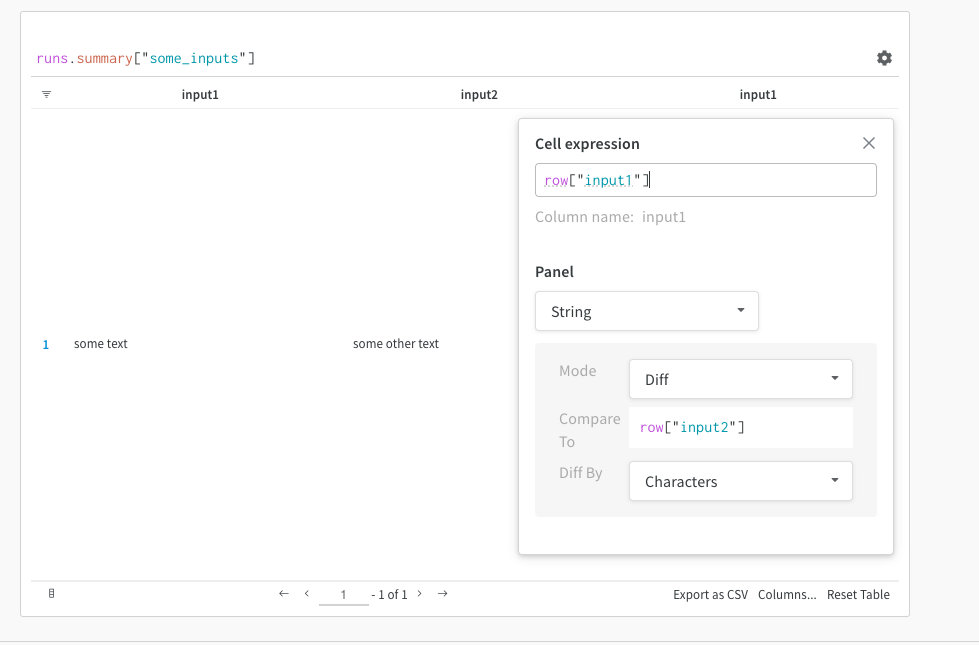

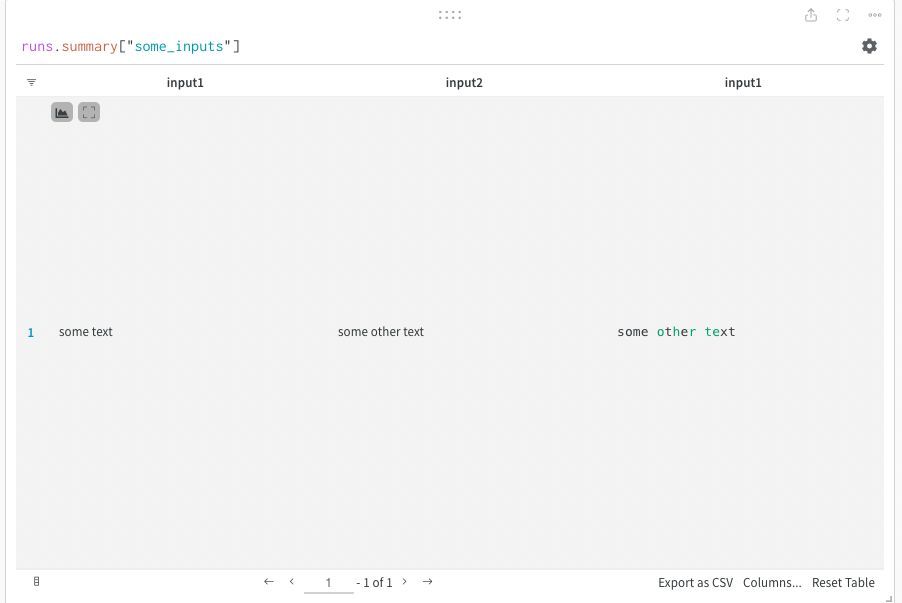

## Pytorch

Now let's take a look at some code that actually trains a neural network and logs metrics and predictions to Weights & Biases. The code below trains a simple convolutional neural network (CNN) to classify images of clothing from the Fashion MNIST dataset. There are a few cool ways that the code below uses `wandb` to keep track of each execution.

1. `wandb.watch` - This function from the `wandb` library allows you to automatically record gradients, parameter distributions, and network topology for any `torch` based model.

2. Every 25 training steps, we log the average loss over the previous 25 steps as well as a `wandb.Histogram` the losses recorded in each of the previous 25 batches, which will allow us to see how the distribution of batch losses shifts over the course of training.

3. We also load the examples and predictions from the first batch of every epoch into a `wandb.Table`.



In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import FashionMNIST

In [ ]:
class FashionCNN(nn.Module):
  """Simple CNN for Fashion MNIST."""

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out


def train_fmnist(config):
  # Pass config into wandb.init
  with wandb.init(config=config) as run:

    # Training setup
    config = run.config
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = FashionCNN()
    model.to(device)
    train_dataset = FashionMNIST("./data/", download=True, train=True, transform=transforms.ToTensor())
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, pin_memory=True)
    error = nn.CrossEntropyLoss()
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # We can pass our network to wandb.watch and automatically log gradients,
    # weights, topology, and more...
    run.watch(model, log="all", log_graph=True)

    # Epoch loop
    iter = 0
    losses = []
    for epoch in range(config.epochs):

      # Iterate over batches of the data
      for idx, (images, labels) in enumerate(train_loader):

        iter += 1
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = error(outputs, labels)
        losses.append(loss.item())

        if iter % 25 == 1:
          run.log(
            {
              "train/loss": sum(losses)/len(losses),  # Log average loss
              "train/losses": wandb.Histogram(losses)  # Log all losses
            }
          )
          losses = []

        # Log the predictions from the first training batch as a wandb.Table
        if idx == 0:
          table = wandb.Table(columns=["image", "label", "prediction"])
          for im, lab, pred in zip(images, labels, outputs):
            pred = torch.argmax(pred)
            table.add_data(wandb.Image(im.cpu()), lab.item(), pred.item())
          run.log({"train/predictions": table})

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
# Training hyperparamters
config = {
  "learning_rate": 0.0001,
  "batch_size": 256,
  "epochs": 5,
}
train_fmnist(config)

## Tensorflow

You can, of course, add `wandb.init` and `wandb.log` calls to track any python compute, including a job that trains a model using `tensorflow`. However, if you already have `tensorboard` logging set up in a `tensorflow` project, you can simply pass the `sync_tensorboard=True` argument to `wandb.init` and all metrics written to tensorboard will be automatically synced to Weights & Biases!

In [ ]:
import tensorflow as tf

In [ ]:
def build_model(config):
  """Construct a simple neural network."""
  model = tf.keras.models.Sequential(
    [
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(config.layer_1, activation=config.activation_1),
      tf.keras.layers.Dropout(config.dropout),
      tf.keras.layers.Dense(config.layer_2, activation=config.activation_2),
    ]
  )
  model.compile(optimizer=config.optimizer, loss=config.loss, metrics=[config.metric])
  return model


def train_mnist():

  # Default training hyperparameters
  config = {
    "layer_1": 512,
    "activation_1": "relu",
    "dropout": 0.25,
    "layer_2": 10,
    "activation_2": "softmax",
    "optimizer": "sgd",
    "loss": "sparse_categorical_crossentropy",
    "metric": "accuracy",
    "epoch": 5,
    "batch_size": 256,
}

  # Passes in config and sets sync_tensorboard=True
  with wandb.init(config=config, sync_tensorboard=True) as run:

      # run.config or wandb.config


      # Build model and prepare data
      model = build_model(run.config)
      mnist = tf.keras.datasets.mnist
      (x_train, y_train), (x_test, y_test) = mnist.load_data()

      # Trains model and passes in TensorBoard callback. This will log metrics
      # and weight histograms. Because we set sync_tensorboard=True, the tensorboard
      # files will be passed to Weights & Biases.
      model.fit(
          x=x_train,
          y=y_train,
          epochs=run.config.epoch,
          batch_size=run.config.batch_size,
          validation_data=(x_test[:100], y_test[:100]),
          callbacks=[tf.keras.callbacks.TensorBoard(histogram_freq=1)],
      )

      # Log model weights to Weights & Biases as an Artifact
      model.save("model.keras")
      model_artifact = wandb.Artifact(name="mnist-model", type="model")
      model_artifact.add_file("model.keras")
      # If you are writing model to cloud storage, you can track it with:
      # model_artifact.add_reference("s3://<your-bucket>/.../model.keras")
      # or
      # model_artifact.add_reference("gs://<your-bucket>/.../model.keras")
      run.log_artifact(model_artifact)


## Running a Sweep 🧹

Now that your hyperparameters are stored in the `wandb.config`, you can use Sweeps to automatically tune your hyperparameters. There are basically two steps
1. Create and upload a sweep config.
2. Start a sweep agent or agents.

You can do (1) from a notebook by passing a dictionary config to `wandb.sweep` or on from the command line with a yaml config by running `wandb sweep config.yaml`.

You can do (2) from a notebook by your train function to `wandb.agent` or from the command line by specifying a program name in your config that will be run by invoking `wandb agent`.


In [ ]:
import yaml


sweep_config = yaml.safe_load(
"""
method: bayes
metric:
  name: validation/epoch_loss
  goal: minimize
parameters:
  dropout:
    distribution: uniform
    min: 0.1
    max: 0.5
  batch_size:
    values: [128, 256]
  epochs:
    distribution: int_uniform
    min: 1
    max: 5
  optimizer:
    values: [adam, sgd]
""")


sweep_id = wandb.sweep(sweep_config)

In [ ]:
wandb.agent(sweep_id, train_mnist, count=5)

## XGBoost

Some machine learning frameworks don't give ask the user to write the training loop themselves, but instead allow customization of a standard training loop through hooks and callbacks, for example fastai, pytorch lightning, keras, and xgboost. Such frameworks also provide basic mechanisms for defining and reporting metrics throughout training.

For all the frameworks above (and many more) Weights & Biases provides an out of the box integration. The cells below use XGBoost to train a regressor that predicts the price of a home in CA from a standard dataset. By providing the `wandb.xgboost.WandbCallback` when we train the regressor, all evaluation metrics defined through the standard XGBoost interface and feature importances will be recorded to W&B automatically.

In [ ]:
import xgboost as xgb
from wandb.xgboost import WandbCallback
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

In [ ]:
# Fetch the CA housing dataset
data = fetch_california_housing(as_frame=True)
df = data.data
df[data.target.name] = data.target
df_train, df_valid = train_test_split(df, test_size=0.2)
features = ["HouseAge",	"AveRooms",	"AveBedrms",	"Population",	"AveOccup",	"Latitude",	"Longitude"]
label = "MedHouseVal"

# Construct DMatrix objects from our dataframe
train_data = xgb.DMatrix(df_train[features], label=df_train[label])
valid_data = xgb.DMatrix(df_valid[features], label=df_valid[label])

# Pass the WandbCallback to train or fit
with wandb.init():
  xgb.train(
      {},
      train_data,
      20,
      evals=[(valid_data, "validation")],
      callbacks=[WandbCallback()]
  )

In [ ]:
Trace?